# Poisson Regression for Predicting Count Data

In this project, we implement Poisson regression to predict count data. Poisson regression is a type of Generalized Linear Model (GLM) suitable for modeling count data and contingency tables. It assumes the response variable follows a Poisson distribution.

## Theory

The Poisson distribution is given by:

$$
p(y; \lambda) = \frac{e^{-\lambda} \lambda^y}{y!}
$$

It belongs to the exponential family and can be expressed in the canonical form:

$$
p(y; \eta) = \exp\left( y\eta - e^{\eta} - \log(y!) \right)
$$

where the natural parameter is $\eta = \log(\lambda)$.

In Poisson regression, we model the natural parameter as a linear combination of input features:

$$
\eta = \theta^T x
$$

We use gradient ascent to maximize the log-likelihood of the observed data with respect to the parameters $\theta$.
"""

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln  # Import gammaln for log-factorial computation

In [18]:
class PoissonRegression:
    """
    Poisson Regression using Gradient Ascent.

    Attributes:
        step_size: Learning rate for gradient ascent.
        max_iter: Maximum number of iterations.
        eps: Threshold for convergence.
        theta: Parameters of the model.
        verbose: Whether to print progress during training.
    """

    def __init__(self, step_size=1e-5, max_iter=100000, eps=1e-5,
                 theta_init=None, verbose=True):
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.theta = theta_init
        self.verbose = verbose

    def fit(self, X, y):
        """
        Fit the model using gradient ascent.

        Args:
            X: Input features, shape (n_samples, n_features)
            y: Target counts, shape (n_samples,)
        """
        n_samples, n_features = X.shape

        if self.theta is None:
            self.theta = np.zeros(n_features)

        for iteration in range(self.max_iter):
            eta = np.dot(X, self.theta)
            mu = np.exp(eta)  # Predicted counts

            gradient = np.dot(X.T, y - mu)

            theta_old = self.theta.copy()
            self.theta += self.step_size * gradient

            # Check convergence
            if np.linalg.norm(self.theta - theta_old, ord=1) < self.eps:
                if self.verbose:
                    print(f'Converged at iteration {iteration}')
                break

            if self.verbose and iteration % 1000 == 0:
                # Compute log-likelihood using gammaln for log-factorial
                ll = np.sum(y * eta - mu - gammaln(y + 1))
                print(f'Iteration {iteration}, Log-Likelihood: {ll:.4f}')

    def predict(self, X):
        """
        Predict expected counts for inputs X.

        Args:
            X: Input features, shape (n_samples, n_features)

        Returns:
            mu: Predicted expected counts, shape (n_samples,)
        """
        eta = np.dot(X, self.theta)
        mu = np.exp(eta)
        return mu

In [19]:
def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.ones((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 1:] = x
    return new_x

In [20]:
def load_dataset(csv_path, label_col='y', add_intercept_flag=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 't').
         add_intercept_flag: Boolean flag to add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """
    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    y_col = headers.index(label_col)
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=y_col)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept_flag:
        inputs = add_intercept(inputs)

    return inputs, labels


Iteration 0, Log-Likelihood: -41395.8945
Converged at iteration 285


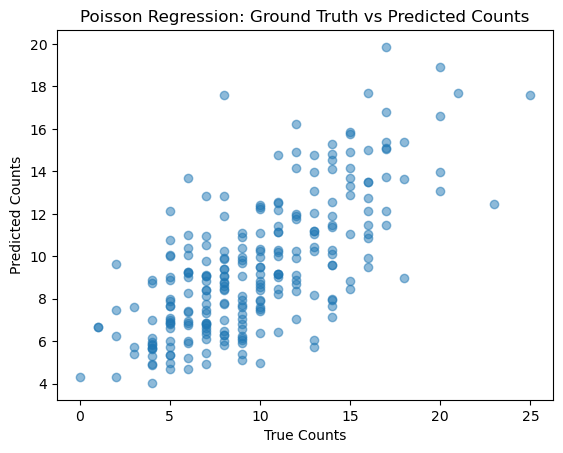

Mean Squared Error (MSE): 10.0369
Mean Absolute Error (MAE): 2.4762
Root Mean Squared Error (RMSE): 3.1681
Poisson Deviance: 278.1975


In [22]:
def main():
    """
    Main function to run Poisson regression.
    """
    # Load training set
    X_train, y_train = load_dataset('data/train_poisson.csv', add_intercept_flag=True)

    # Load validation set
    X_valid, y_valid = load_dataset('data/valid_poisson.csv', add_intercept_flag=True)

    # Train Poisson regression model
    model = PoissonRegression(step_size=1e-5, max_iter=100000, verbose=True)
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_valid)

    # Plot ground truth vs predicted counts
    plt.figure()
    plt.scatter(y_valid, y_pred, alpha=0.5)
    plt.xlabel('True Counts')
    plt.ylabel('Predicted Counts')
    plt.title('Poisson Regression: Ground Truth vs Predicted Counts')
    plt.savefig('poisson_regression_plot.png')
    plt.show()
    
    # Compute evaluation metrics
    mse = np.mean((y_valid - y_pred) ** 2)
    mae = np.mean(np.abs(y_valid - y_pred))
    rmse = np.sqrt(mse)

    # Poisson Deviance
    # Adding a small epsilon to y_pred to avoid log(0)
    epsilon = 1e-8
    y_pred_safe = y_pred + epsilon
    y_valid_safe = y_valid + epsilon
    poisson_deviance = 2 * np.sum(y_valid * np.log(y_valid_safe / y_pred_safe) - (y_valid - y_pred))

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Poisson Deviance: {poisson_deviance:.4f}")

if __name__ == '__main__':
    main()